# Batch scheduling of a fermentation process

Industrial fermentation processes are generally batch operations. The process consists of a
number of phases or stages, each of which requires a considerable amount of time. Because
of the time factor, the system cannot react quickly to variations in demand, so that the
scheduling of production in each stage is of considerable importance.

Consider a fermentation process which has five stages: (1) Mixing and cooking [M,m]; (2) Fermentation [F,f]; (3) Purification [P,p]; (4) Blending and packaging [B,b]; (5) Warehousing [W,w].

$m_i$ ($f_i$, $p_i$, etc.) is the quantity that goes into stage $m$ (from the previous stage) in period $i$; a period may be a week, a day, or even a shift. In our case, we will look at daily periods, i.e. each $i$ is one day. $d_i$ is the demand (by customers) from the warehouse in period $i$. The demand $d_i$ is known (but not precisely). Given $d_i$, a set of values $m_i$, $f_i$, $p_i$, $b_i$, $w_i$ constitutes a production schedule. The capital letters indicate the total quantity in the stage, i.e. $M_j$ is the total amount of material in the mixing stage in period $j$.

The basic cost factor in every stage is the labor cost, if only that portion of variable costs which depends on the production rate of a stage is considered. Extra production may require overtime operations by the crews, which include both production and "clean-up" workers. Overtime production in a stage will be indicated by a prime ($m_i'$), and the costs are indicated as $C_m$ for the cost/man-hour for straight time labor in stage $m$, and $C_m'$ for the cost/man-hour for overtime labor in stage $m$.

A planning horizon is considered to be a large number of periods ($i$); for our production schedule, the planning horizon is a 3-months' duration, $1\leq i\leq N$, where $N=105$.

### A note on unit selection
It is a good idea to select the unit you will be using from the start, especially considering factors of 10 [such as kg, tonnes etc.]. In this example, we will always use $1000L$ as our unit.

## Variable selection
Based on these considerations, we know that we will have to consider the quantities produced in regular time and overtime in their changes (i.e. $m_i$, $m_i'$). However, we only have to look at the total quantities as outputs ($M_i$).

Note that due to 0-indexing, we have $0\leq i\leq N-1$.

In [1]:
from docplex.mp.model import Model
import numpy as np
from sys import stdout
import matplotlib.pyplot as plt
import math

mdl = Model(name="Batch scheduling")

# This is required due to 1 indexing instead of 0 indexing
N = 105
d = np.array([0 for i in range(20)])
#d = np.append(d,np.array([3 for i in range(N-20)]))
#d = np.append(d,np.array([4 for i in range(N-20)]))
#d = np.append(d,np.array([4.5 for i in range(N-20)]))
d = np.append(d, np.array([5+math.sin(i/10) for i in range(N-20)]))
t_m = 3
A_max = 8
Z_b = 5

In [2]:
m = mdl.continuous_var_list(N, lb=0, name="Delta_Mixing")
m_prime = mdl.continuous_var_list(N, lb=0, name="Delta_Mixing_Prime")
M = mdl.continuous_var_list(N, lb=0, name="Mixing")

f = mdl.continuous_var_list(N, lb=0, name="Delta_Fermentation")
f_prime = mdl.continuous_var_list(N, lb=0, name="Delta_Fermentation_Prime")
F = mdl.continuous_var_list(N, lb=0, name="Fermentation")

p = mdl.continuous_var_list(N, lb=0, name="Delta_Purification")
p_prime = mdl.continuous_var_list(N, lb=0, name="Delta_Purification_Prime")
P = mdl.continuous_var_list(N, lb=0, name="Purification")

b = mdl.continuous_var_list(N, lb=0, name="Delta_Blending")
b_prime = mdl.continuous_var_list(N, lb=0, name="Delta_Blending_Prime")
B = mdl.continuous_var_list(N, lb=0, name="Blending")

w = mdl.continuous_var_list(N, lb=0, name="Delta_Warehousing")
w_prime = mdl.continuous_var_list(N, lb=0, name="Delta_Warehousing_Prime")
W = mdl.continuous_var_list(N, lb=0, name="Warehousing")

### Auxiliary variables
As you may imagine, many of the constraints will look at the "amount of inflow" etc., i.e. considering $m_i$ and $m_i'$ together. This means, for readability and model structure purposes, it makes sense to introduce auxiliary variables $m_{i,all} = m_i + m_i'$.

You may think that these auxiliary variables lessen computational performance, but in reality this is actually rarely the case, as the solvers are able to understand this (and sometimes even use these logical relationships). Therefore, it is recommended to introduce these variables when needed, and only remove them if you have serious performance problems and would like to check whether this helps reduce the computational cost.

In [3]:
m_all = mdl.continuous_var_list(N, lb=0, name="Delta_Mixing_all")
f_all = mdl.continuous_var_list(N, lb=0, name="Delta_Fermentation_all")
p_all = mdl.continuous_var_list(N, lb=0, name="Delta_Purification_all")
b_all = mdl.continuous_var_list(N, lb=0, name="Delta_Blending_all")
w_all = mdl.continuous_var_list(N, lb=0, name="Delta_Warehousing_all")

mdl.add_constraints([m_all[i] == m[i] + m_prime[i] for i in range(N)]);
mdl.add_constraints([f_all[i] == f[i] + f_prime[i] for i in range(N)]);
mdl.add_constraints([p_all[i] == p[i] + p_prime[i] for i in range(N)]);
mdl.add_constraints([b_all[i] == b[i] + b_prime[i] for i in range(N)]);
mdl.add_constraints([w_all[i] == w[i] + w_prime[i] for i in range(N)]);

### Linking variables together
It is often a good idea to get the "logical" constraints out of the way first, i.e. the constraints that link variable $A$ and $B$ [similarly to what we have done with the auxiliary variables]. In this case, we link the "Delta" variables with the overall quantities.

For example, let's consider the fermentation process. Mathematically, this can be described as:

$F_j = \sum \limits_{i=0}^{j} (f_{i,all} - p_{i,all})$,

where $F_j$ is the total quanitity in the fermentation at period $j$. Similarly, we can define:

$M_j = \sum \limits_{i=0}^{j} (m_{i,all} - f_{i,all})$

$P_j = \sum \limits_{i=0}^{j} (p_{i,all} - b_{i,all})$

$B_j = \sum \limits_{i=0}^{j} (b_{i,all} - w_{i,all})$

$W_j = \sum \limits_{i=0}^{j} (w_{i,all} - d_{i})$

Therefore, putting this into CPLEX, we get:

In [4]:
mdl.add_constraints([M[j] == mdl.sum(m_all[i] - f_all[i] for i in range(j+1)) for j in range(N)]);
mdl.add_constraints([F[j] == mdl.sum(f_all[i] - p_all[i] for i in range(j+1)) for j in range(N)]);
mdl.add_constraints([P[j] == mdl.sum(p_all[i] - b_all[i] for i in range(j+1)) for j in range(N)]);
mdl.add_constraints([B[j] == mdl.sum(b_all[i] - w_all[i] for i in range(j+1)) for j in range(N)]);
mdl.add_constraints([W[j] == mdl.sum(w_all[i] - d[i] for i in range(j+1)) for j in range(N)]);

## Constraint modelling
Now that we have established the variables, let's look at the constraints:

"For each schedule, the mixing and cooking stage is of fixed duration, $t_m = 3$ periods":
$f_{i,all} = m_{i-t_m,all}$

In [5]:
mdl.add_constraints([f_all[i] == m_all[i-t_m] for i in range(N) if i >= t_m]);

There is a minimum time required for fermentation and a maximum time allowed by the process. The minimum time is 10 days, and the maximum time is 30 days.

Mathematically, this means:

$\sum \limits_{n=0}^9 f_{j-n,all} \leq F_j \leq \sum \limits_{n=0}^{29} f_{j-n,all}$

This constraint is actually quite non-obvious. It basically states that the overall quantity in the fermentation process has to be at least what has been added in the last 10 days (represented by the flow variables) but may not exceed what has been added in the last 30 days. Remember: if you have trouble formulating a constraint, think about how you would write it down with words, assign each word a variable and make it a formula.

Also, this constraint relies on the subtle assumption that you always take out of the fermenter first what has been added first (i.e. first-in first-out).

In [6]:
mdl.add_constraints([F[j] >= mdl.sum(f_all[j-n] for n in range(min(j+1,10))) for j in range(N)]);
mdl.add_constraints([F[j] <= mdl.sum(f_all[j-n] for n in range(min(j+1,30))) for j in range(N)]);

"The purification process requires a minimum of 2 days and a maximum of 5 days."

Analogously to the fermentation constraint, this means:

$\sum \limits_{n=0}^1 p_{j-n,all} \leq P_j \leq \sum \limits_{n=0}^{4} p_{j-n,all}$


In [7]:
mdl.add_constraints([P[j] >= mdl.sum(p_all[j-n] for n in range(min(j+1,2))) for j in range(N)]);
mdl.add_constraints([P[j] <= mdl.sum(p_all[j-n] for n in range(min(j+1,5))) for j in range(N)]);

"Blending and packaging takes one day to perform schedule; the total amount passing through the blending stage is restricted only by capacity $Z_b = 5000L$."

Mathematically, this means:

$w_{i,all} = b_{i-1,all}$

$B_i \leq Z_b$

In [8]:
mdl.add_constraints([w_all[i] == b_all[i-1] for i in range(N) if i >= 1]);
mdl.add_constraints([B[i] <= Z_b for i in range(N)]);

"Warehousing is limited by the age of the product or warehouse capacity or demand, where $A_{\max} = 8$ is the maximum number of time periods allowed for storage."

Mathematically, this means:

$W_j \leq \sum \limits_{n=0}^{A_{\max}} w_{j-n,all}$

In [9]:
mdl.add_constraints([W[j] <= mdl.sum(w_all[j-n] for n in range(min(j+1,A_max+1))) for j in range(N)]);

"There are restrictions on the available man hours in any stage for both straight time and overtime", e.g. $H_{m_i}$ are the max. available hours in mixing in period $i$ for straight time.

Mathematically, this can be translated into:

$m_i\mu \leq H_{m_i}$

$m_i'\mu \leq H_{m_i}'$

where $\mu$ is the number of man hours/unit of production in mixing. Similar relations hold for the other processes.

In [10]:
H_m = 200; H_mPrime = 40; mu = 2;
H_f = 250; H_fPrime = 250; phi = 5;
H_p = 200; H_pPrime = 150; pi = 7;
H_b = 600; H_bPrime = 100; beta = 2;
H_w = 400; H_wPrime = 400; chi = 1;

mdl.add_constraints([m[i]*mu <= H_m for i in range(N)]);
mdl.add_constraints([m_prime[i]*mu <= H_mPrime for i in range(N)]);
mdl.add_constraints([f[i]*phi <= H_f for i in range(N)]);
mdl.add_constraints([f_prime[i]*phi <= H_fPrime for i in range(N)]);
mdl.add_constraints([p[i]*pi <= H_p for i in range(N)]);
mdl.add_constraints([p_prime[i]*pi <= H_pPrime for i in range(N)]);
mdl.add_constraints([b[i]*beta <= H_b for i in range(N)]);
mdl.add_constraints([b_prime[i]*beta <= H_bPrime for i in range(N)]);
mdl.add_constraints([w[i]*chi <= H_w for i in range(N)]);
mdl.add_constraints([w_prime[i]*chi <= H_wPrime for i in range(N)]);

## Objective function
Finally, we got through all the constraints and can have a look at the objective, which is surprisingly easy, as we only consider labor costs:

$Z = K_m + K_f + K_p + K_b + K_w$

where e.g.

$K_{m} = C_m \mu \sum \limits_{i=0}^{N-1} m_i + C_m' \mu \sum \limits_{i=0}^{N-1} m_i'$

with $C_m$ as the labor cost per hour.

In [11]:
C_m = 350; C_mPrime = 700;
C_f = 410; C_fPrime = 800;
C_p = 380; C_pPrime = 1000;
C_b = 250; C_bPrime = 500;
C_w = 200; C_wPrime = 300;

K_m = C_m*mu*mdl.sum(m[i] for i in range(N)) + C_mPrime*mu*mdl.sum(m_prime[i] for i in range(N))
K_f = C_f*phi*mdl.sum(f[i] for i in range(N)) + C_fPrime*phi*mdl.sum(f_prime[i] for i in range(N))
K_p = C_p*pi*mdl.sum(p[i] for i in range(N)) + C_pPrime*pi*mdl.sum(p_prime[i] for i in range(N))
K_b = C_b*beta*mdl.sum(b[i] for i in range(N)) + C_bPrime*beta*mdl.sum(b_prime[i] for i in range(N))
K_w = C_w*chi*mdl.sum(w[i] for i in range(N)) + C_wPrime*chi*mdl.sum(w_prime[i] for i in range(N))

mdl.minimize(K_m+K_f+K_p+K_b+K_w)

In [12]:
msol = mdl.solve()

## Post-processing
### Demand satisfaction
Now let's look at the solution of this. First, let's see that the demand is satisfied by plotting the inflow into the warehouse, $w_{all}$, the amount stored in the warehouse, $W$ as well as the demand.

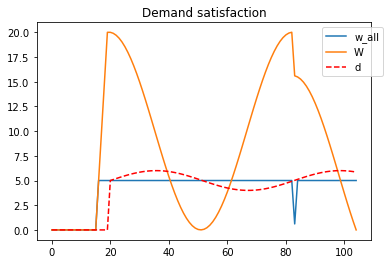

In [13]:
plt.plot(range(N),mdl.solution.get_values(w_all),label="w_all")
plt.plot(range(N),mdl.solution.get_values(W), label="W")
plt.plot(range(N), d, 'r--',label="d")
plt.title('Demand satisfaction')
plt.legend(bbox_to_anchor=(1.05, 1));

### Inflow conditions
Next, let's look at the inflows by themselves:

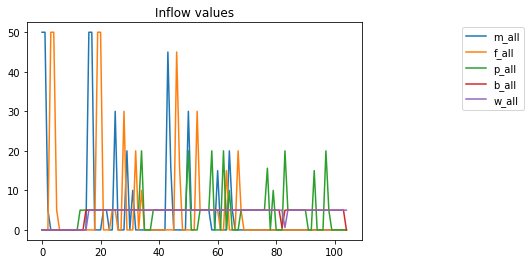

In [14]:
plt.plot(range(N),mdl.solution.get_values(m_all),label="m_all")
plt.plot(range(N),mdl.solution.get_values(f_all), label="f_all")
plt.plot(range(N),mdl.solution.get_values(p_all),label="p_all")
plt.plot(range(N),mdl.solution.get_values(b_all), label="b_all")
plt.plot(range(N),mdl.solution.get_values(w_all), label="w_all")
plt.title('Inflow values')
plt.legend(bbox_to_anchor=(1.5, 1));

As we may expect, there are three phases to this: startup, steady-state and shut-down. This theory can be tested by expanding $N$ and observing the extension of the steady-state period.

### Quantities
Next, let's look at the quantities by themselves:

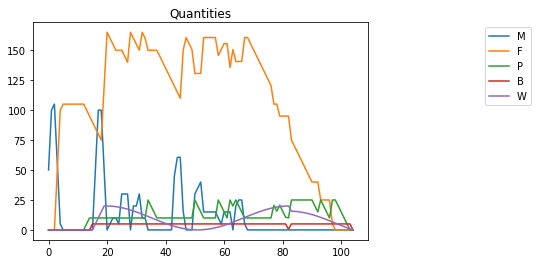

In [15]:
plt.plot(range(N),mdl.solution.get_values(M),label="M")
plt.plot(range(N),mdl.solution.get_values(F), label="F")
plt.plot(range(N),mdl.solution.get_values(P),label="P")
plt.plot(range(N),mdl.solution.get_values(B), label="B")
plt.plot(range(N),mdl.solution.get_values(W), label="W")
plt.title('Quantities')
plt.legend(bbox_to_anchor=(1.5, 1));

This is very interesting: at around the 80 day mark, we can see that the mixing process spikes. This is presumably so that it can be "switched off" afterwards, and thus saving the labor cost. However, it is limited by how much it can mix by the fermentation process, which has a time limit on it. A variation on the minimum and maximum mixing time shows that this is the crucial step for the shut-down in this case.

### Straight time versus overtime
Now let's look how the overtime is used and when:

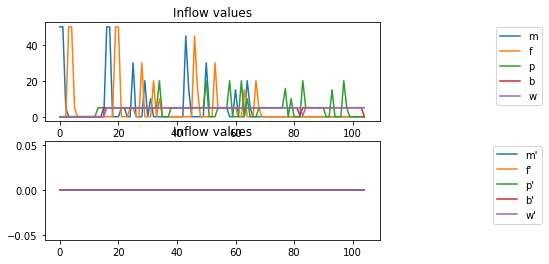

In [16]:
plt.subplot(211)
plt.plot(range(N),mdl.solution.get_values(m),label="m")
plt.plot(range(N),mdl.solution.get_values(f), label="f")
plt.plot(range(N),mdl.solution.get_values(p),label="p")
plt.plot(range(N),mdl.solution.get_values(b), label="b")
plt.plot(range(N),mdl.solution.get_values(w), label="w")
plt.title('Inflow values')
plt.legend(bbox_to_anchor=(1.5, 1));

plt.subplot(212)
plt.plot(range(N),mdl.solution.get_values(m_prime),label="m'")
plt.plot(range(N),mdl.solution.get_values(f_prime), label="f'")
plt.plot(range(N),mdl.solution.get_values(p_prime),label="p'")
plt.plot(range(N),mdl.solution.get_values(b_prime), label="b'")
plt.plot(range(N),mdl.solution.get_values(w_prime), label="w'")
plt.title('Inflow values')
plt.legend(bbox_to_anchor=(1.5, 1));

So we can see that we need no overtime at all to satisfy this demand! This in return means we can do the same job with less people.